In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [12]:
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True,
with_info=True)

In [13]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [14]:
 class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

2022-06-09 11:41:23.370276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


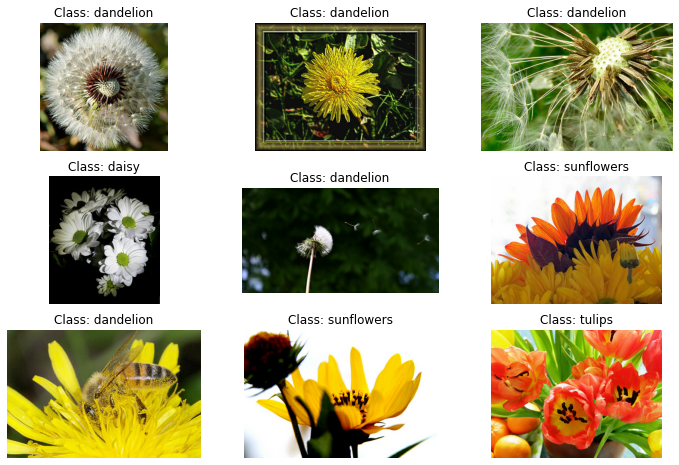

In [15]:
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9) 
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label])) 
    plt.axis("off")

plt.show(block=False)

In [16]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224]) 
    return resized_image, label

In [17]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

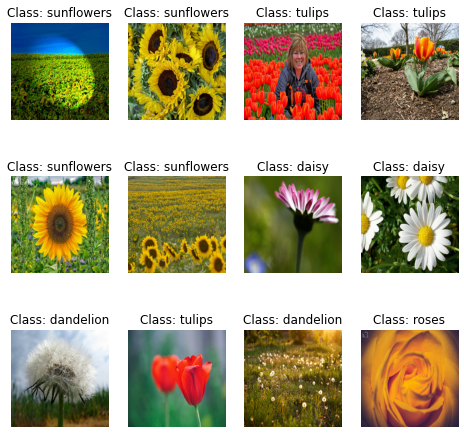

In [19]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")

plt.show()

### 2.2.2. Budowa sieci

In [26]:
from functools import partial

In [43]:
# DefaultConv2D = partial(keras.layers.Conv2D,  keras.layers.Dropout(0.5),
#                     kernel_size=3,
#                     activation='relu',
#                     padding="SAME")

DefaultConv2D = partial(keras.layers.Conv2D, keras.layers.Dropout(0.5), kernel_size=3,
                        activation="relu", padding="SAME")


In [44]:
DefaultConv2D(filters=64, kernel_size=7,
              input_shape=[28, 28, 1])

TypeError: __init__() got multiple values for argument 'filters'

In [50]:
model = keras.models.Sequential([
    keras.layers.Rescaling(scale=1./127.5, offset=-1),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=7),
    keras.layers.Conv2D(filters=128, kernel_size=7),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=7),
    keras.layers.Conv2D(filters=256, kernel_size=7),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')])
    

In [ ]:
DefaultConv2D(filters=64)

In [56]:
model.compile(optimizer='adam', metrics=[tf.keras.metrics.Accuracy()], loss='mean_squared_error')

In [57]:
model.fit(train_set, validation_data=valid_set,
                    epochs=5)

Epoch 1/5


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/metrics.py", line 729, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/keras/metrics.py", line 3985, in accuracy  **
        y_true.shape.assert_is_compatible_with(y_pred.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


### 2.3 Uczenie transferowe

In [37]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image) 
    return final_image, label

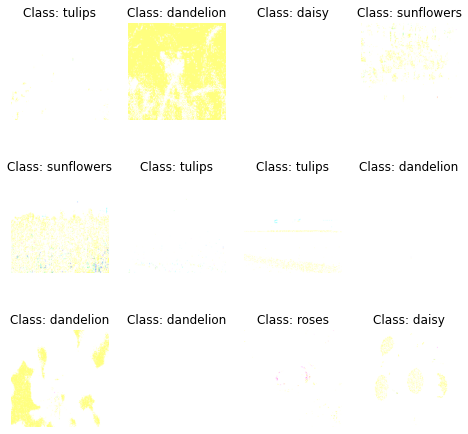

In [38]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")

plt.show()

In [39]:
base_model = tf.keras.applications.xception.Xception( weights="imagenet", include_top=False)

83697664/83683744 [==============================] - 1s 0us/step


In [40]:
for index, layer in enumerate(base_model.layers): 
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act